#  Data Understanding & Exploration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('/kaggle/input/top-100-cryptocurrency-2020-2025/top_100_cryptos_with_correct_network.csv')

In [2]:
print("Dataset shape:", df.shape)
print("Column names:", df.columns.tolist())

Dataset shape: (211679, 7)
Column names: ['symbol', 'date', 'open', 'high', 'low', 'close', 'network']


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   symbol   211679 non-null  object 
 1   date     211679 non-null  object 
 2   open     211679 non-null  float64
 3   high     211679 non-null  float64
 4   low      211679 non-null  float64
 5   close    211679 non-null  float64
 6   network  211679 non-null  object 
dtypes: float64(4), object(3)
memory usage: 11.3+ MB


In [4]:
df.head()

,symbol,date,open,high,low,close,network
0,BTCUSDT,2018-08-01,7735.67,7750.00,7430.00,7604.58,Bitcoin
1,BTCUSDT,2018-08-02,7600.08,7709.46,7455.72,7525.71,Bitcoin
2,BTCUSDT,2018-08-03,7525.71,7540.00,7282.44,7418.78,Bitcoin
3,BTCUSDT,2018-08-04,7412.27,7494.81,6926.00,7009.84,Bitcoin
4,BTCUSDT,2018-08-05,7009.84,7089.87,6882.29,7024.19,Bitcoin


In [5]:
df.tail()

,symbol,date,open,high,low,close,network
211674,UMAUSDT,2025-08-01,1.242,1.251,1.162,1.202,Ethereum
211675,UMAUSDT,2025-08-02,1.202,1.216,1.147,1.172,Ethereum
211676,UMAUSDT,2025-08-03,1.175,1.210,1.158,1.207,Ethereum
211677,UMAUSDT,2025-08-04,1.206,1.247,1.201,1.242,Ethereum
211678,UMAUSDT,2025-08-05,1.243,1.245,1.204,1.234,Ethereum


In [6]:
print(df.isnull().sum())


symbol     0
date       0
open       0
high       0
low        0
close      0
network    0
dtype: int64


In [7]:
display(df.describe(include='all'))


,symbol,date,open,high,low,close,network
count,211679,211679,211679.000000,211679.000000,211679.000000,211679.000000,211679
unique,100,2562,NaN,NaN,NaN,NaN,50
top,BTCUSDT,2022-02-02,NaN,NaN,NaN,NaN,Ethereum
freq,2562,100,NaN,NaN,NaN,NaN,94654
mean,NaN,NaN,628.566155,646.550242,609.654246,629.092910,NaN
std,NaN,NaN,5345.009524,5478.052232,5207.376818,5350.691462,NaN
min,NaN,NaN,0.000043,0.000044,0.000037,0.000043,NaN
25%,NaN,NaN,0.061740,0.064500,0.059095,0.061750,NaN
50%,NaN,NaN,0.418100,0.438400,0.398000,0.418000,NaN
75%,NaN,NaN,4.383000,4.595200,4.165000,4.383000,NaN


# EDA

In [8]:
# I will neeed that for future works in  time series analysis
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


In [9]:
# Sort for chronological accuracy
df = df.sort_values(['symbol', 'date'])


In [10]:
# Check global date range
print(f" Date range: {df['date'].min()} to {df['date'].max()}")

 Date range: 2018-08-01 00:00:00 to 2025-08-05 00:00:00


In [11]:
#  Days count per coin
days_per_coin = df.groupby('symbol')['date'].nunique().sort_values(ascending=False)
print("Top coins by number of days recorded:", days_per_coin.head())


Top coins by number of days recorded: symbol
ADAUSDT    2562
ETCUSDT    2562
XRPUSDT    2562
XLMUSDT    2562
VETUSDT    2562
Name: date, dtype: int64


In [12]:
#  Check if there are any date gaps for each coin
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
missing_dates = {}
for coin, group in df.groupby('symbol'):
    coin_dates = pd.DatetimeIndex(group['date'])
    missing = full_date_range.difference(coin_dates)
    if len(missing) > 0:
        missing_dates[coin] = len(missing)
print(f"Coins with missing days: {len(missing_dates)} / {df['symbol'].nunique()}")

Coins with missing days: 85 / 100


In [13]:
#  Basic stats by coin
coin_stats = df.groupby('symbol').agg(
    avg_price=('close', 'mean'),
    max_price=('close', 'max'),
    min_price=('close', 'min'),
    volatility=('close', lambda x: np.std(x.pct_change()) * 100)
).sort_values(by='avg_price', ascending=False)
print("--- Top coins by average price ---")
print(coin_stats.head())

--- Top coins by average price ---
             avg_price  max_price  min_price  volatility
symbol                                                  
BTCUSDT   35688.334231  119954.42    3211.72    3.353464
YFIUSDT   14993.449945   82885.12    4374.95    6.158508
PAXGUSDT   2115.128914    3487.60    1619.00    0.812771
ETHUSDT    1669.295902    4807.98      83.76    4.444809
MKRUSDT    1658.248658    5981.71     435.20    5.487636


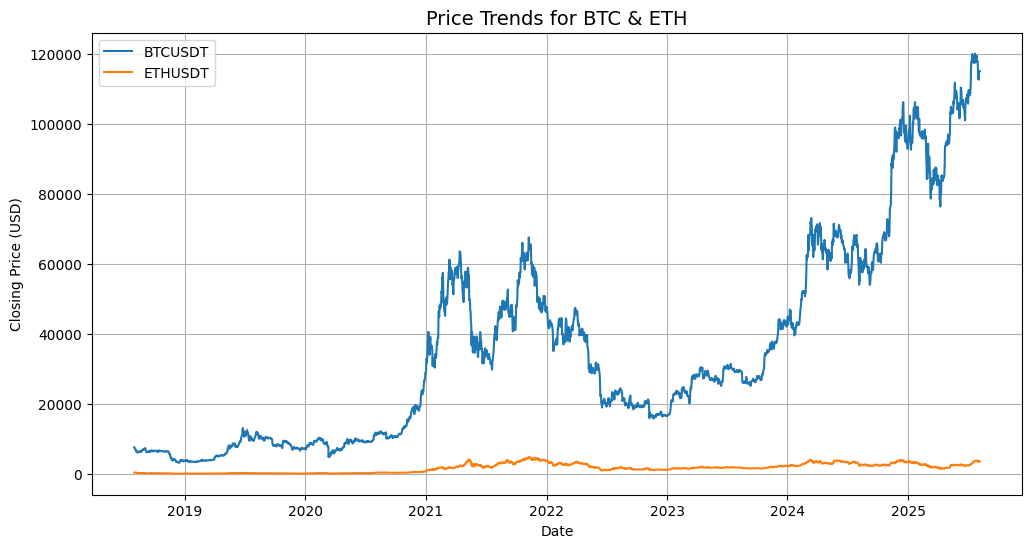

In [14]:
#  Price trends for major coins
import matplotlib.pyplot as plt
import seaborn as sns
top_coins = ['BTCUSDT', 'ETHUSDT']
plt.figure(figsize=(12,6))
for coin in top_coins:
    subset = df[df['symbol'] == coin]
    plt.plot(subset['date'], subset['close'], label=coin)
plt.title("Price Trends for BTC & ETH", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


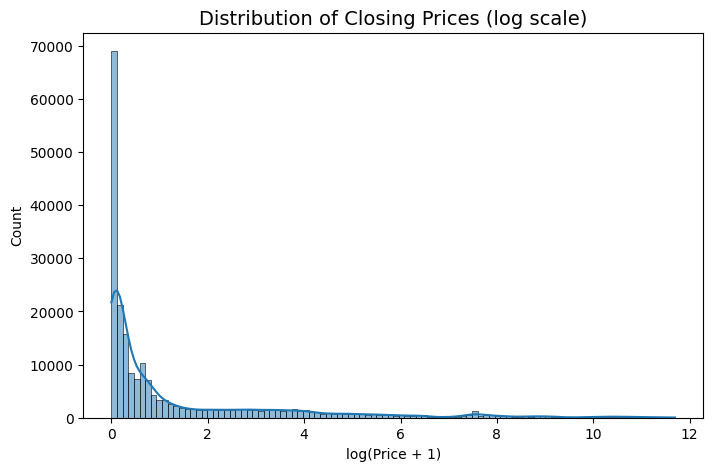

In [15]:
#  Distribution of closing prices (log scale to handle huge range)
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['close']), bins=100, kde=True)
plt.title("Distribution of Closing Prices (log scale)", fontsize=14)
plt.xlabel("log(Price + 1)")
plt.show()

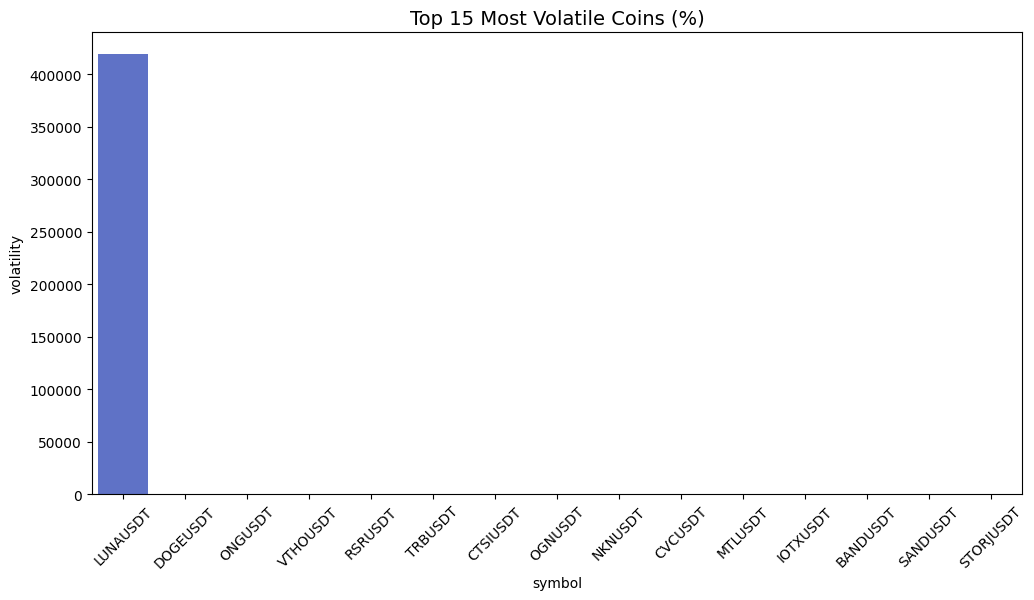

In [16]:
#  Volatility comparison (std dev of daily returns) by coin
vol_df = df.groupby('symbol')['close'].apply(lambda x: np.std(x.pct_change()) * 100).reset_index()
vol_df.columns = ['symbol', 'volatility']
plt.figure(figsize=(12,6))
sns.barplot(data=vol_df.sort_values('volatility', ascending=False).head(15),
            x='symbol', y='volatility', palette='coolwarm')
plt.title("Top 15 Most Volatile Coins (%)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

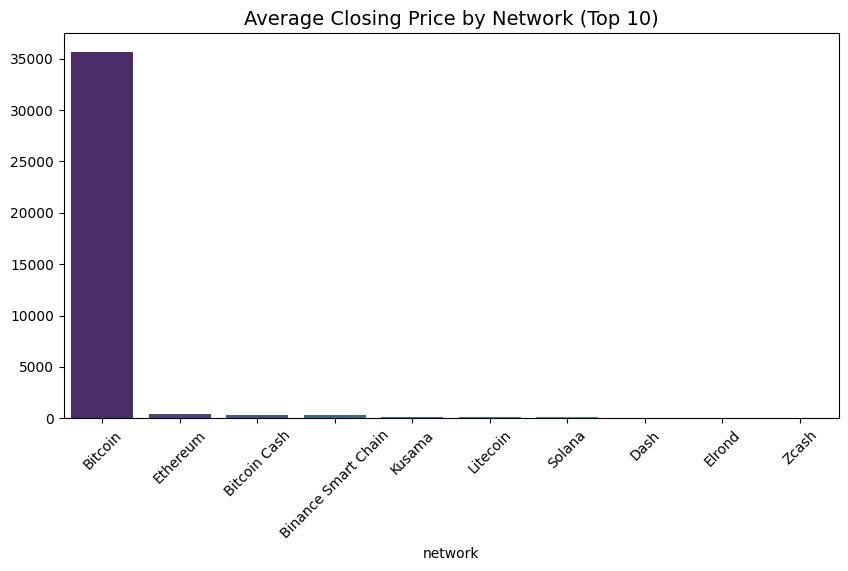

In [17]:
#  Average closing price by network (top 10 networks)
network_prices = df.groupby('network')['close'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=network_prices.index, y=network_prices.values, palette='viridis')
plt.title("Average Closing Price by Network (Top 10)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

*  BTC largely dictates altcoin market direction. ETH follows trend but with higher percentage swings in bulls and worse performance in certain bear phases.
*  The crypto market has extreme price inequality — most coins are “junk tokens” from a price perspective, with only a handful commanding high USD value.
*  Trading note: High-volatility coins allow for big gains but also catastrophic losses — suitable only for short-term momentum strategies, not long holds.
*  BTC has the highest absolute value in average price, but surprisingly low volatility given its market size — it’s the crypto “blue chip.”
*  YFI is an outlier — high dollar price due to rarity, but not a stable store of value.
*  PAXG acts as a risk hedge asset — behaves more like gold than crypto.
*  BTC largely dictates altcoin market direction. ETH follows trend but with higher percentage swings in bulls and worse performance in certain bear phases.
*  The crypto market has extreme price inequality — most coins are “junk tokens” from a price perspective, with only a handful commanding high USD value.
*  High-volatility coins allow for big gains but also catastrophic losses — suitable only for short-term momentum strategies, not long holds.
*   From a market cap-weighted viewpoint, Bitcoin totally dominates. But this chart’s imbalance is because we’re using price not market capitalization — meaning small-supply coins distort network comparisons.


# feature Engineering

In [18]:
def add_features(df):
    df = df.copy()
    
    # Daily returns
    df['return'] = df.groupby('symbol')['close'].pct_change()

    # Relative returns vs BTC
    btc_returns = df[df['symbol'] == 'BTCUSDT'][['date', 'return']].rename(columns={'return': 'btc_return'})
    df = df.merge(btc_returns, on='date', how='left')
    df['excess_return'] = df['return'] - df['btc_return']

    # Rolling volatility & mean (7d, 30d)
    for window in [7, 30]:
        df[f'volatility_{window}d'] = (
            df.groupby('symbol')['return']
              .transform(lambda x: x.rolling(window).std())
        )
        df[f'ma_{window}d'] = (
            df.groupby('symbol')['close']
              .transform(lambda x: x.rolling(window).mean())
        )

    # RSI calculation
    def compute_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    df['rsi_14'] = df.groupby('symbol')['close'].transform(compute_rsi)

    # Coin age in days
    df['coin_age'] = df.groupby('symbol')['date'].transform(lambda x: (x - x.min()).dt.days)

    # Target label
    df['target'] = (df.groupby('symbol')['close'].shift(-1) > df['close']).astype(int)

    return df

df_features = add_features(df)
print(df_features.head(20))


     symbol       date     open     high      low    close  network    return  \
0   ADAUSDT 2018-08-01  0.14152  0.14474  0.13500  0.13984  Cardano       NaN   
1   ADAUSDT 2018-08-02  0.13983  0.14149  0.12850  0.13039  Cardano -0.067577   
2   ADAUSDT 2018-08-03  0.13079  0.13473  0.12290  0.12947  Cardano -0.007056   
3   ADAUSDT 2018-08-04  0.12941  0.13358  0.12353  0.12639  Cardano -0.023789   
4   ADAUSDT 2018-08-05  0.12622  0.13130  0.12440  0.13024  Cardano  0.030461   
5   ADAUSDT 2018-08-06  0.13050  0.13618  0.12644  0.12937  Cardano -0.006680   
6   ADAUSDT 2018-08-07  0.12937  0.13227  0.12252  0.12365  Cardano -0.044214   
7   ADAUSDT 2018-08-08  0.12380  0.12387  0.10855  0.11292  Cardano -0.086777   
8   ADAUSDT 2018-08-09  0.11281  0.12631  0.11272  0.12213  Cardano  0.081562   
9   ADAUSDT 2018-08-10  0.12213  0.12380  0.11132  0.11485  Cardano -0.059609   
10  ADAUSDT 2018-08-11  0.11461  0.11633  0.10713  0.11022  Cardano -0.040313   
11  ADAUSDT 2018-08-12  0.11

* You can see early rows have NaNs in rolling features and RSI — that’s expected because those values require a minimum lookback window (e.g., RSI needs 14 days).

Train range: 2018-08-01 00:00:00 to 2025-02-06 00:00:00
Test range: 2025-02-07 00:00:00 to 2025-08-05 00:00:00


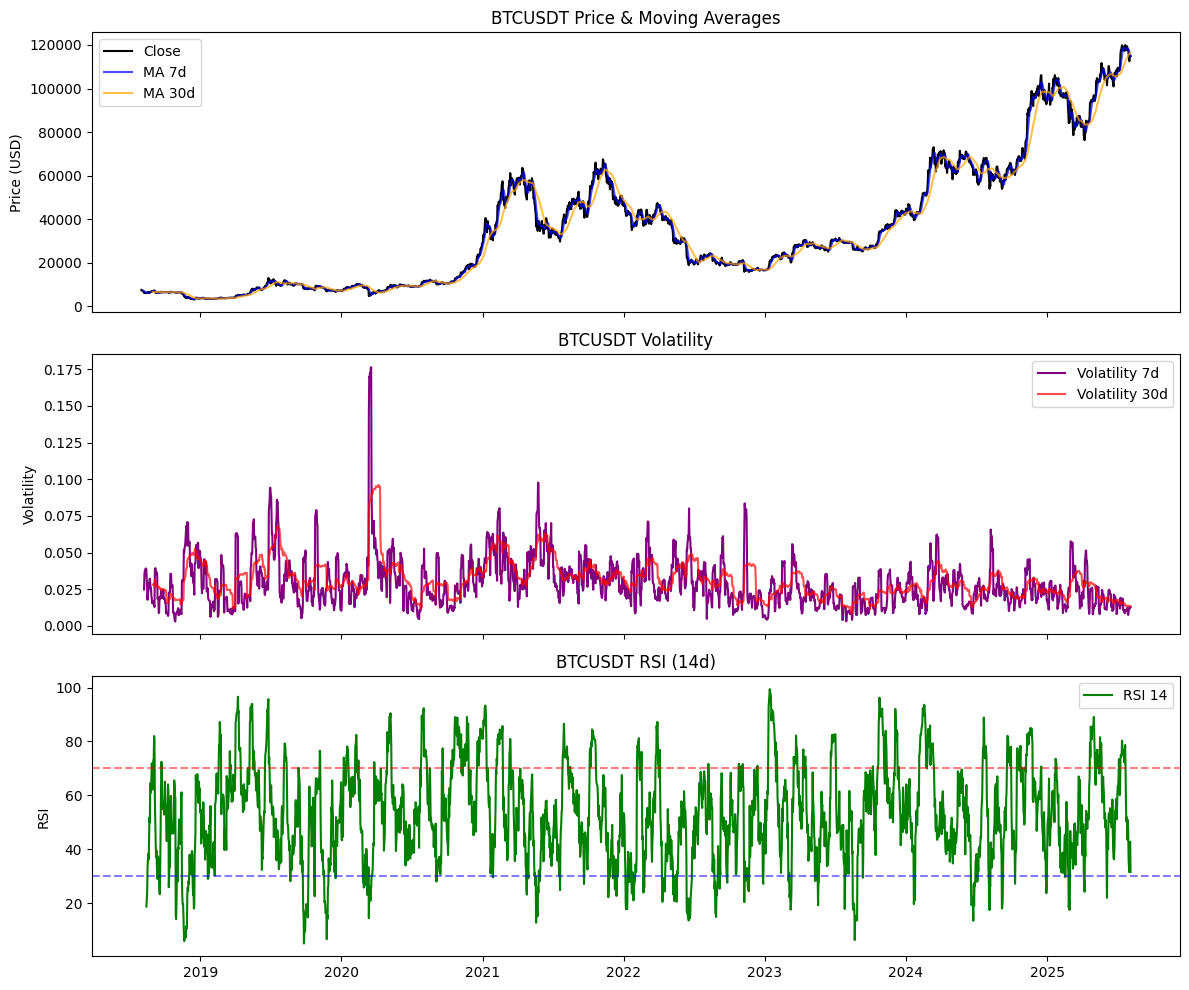

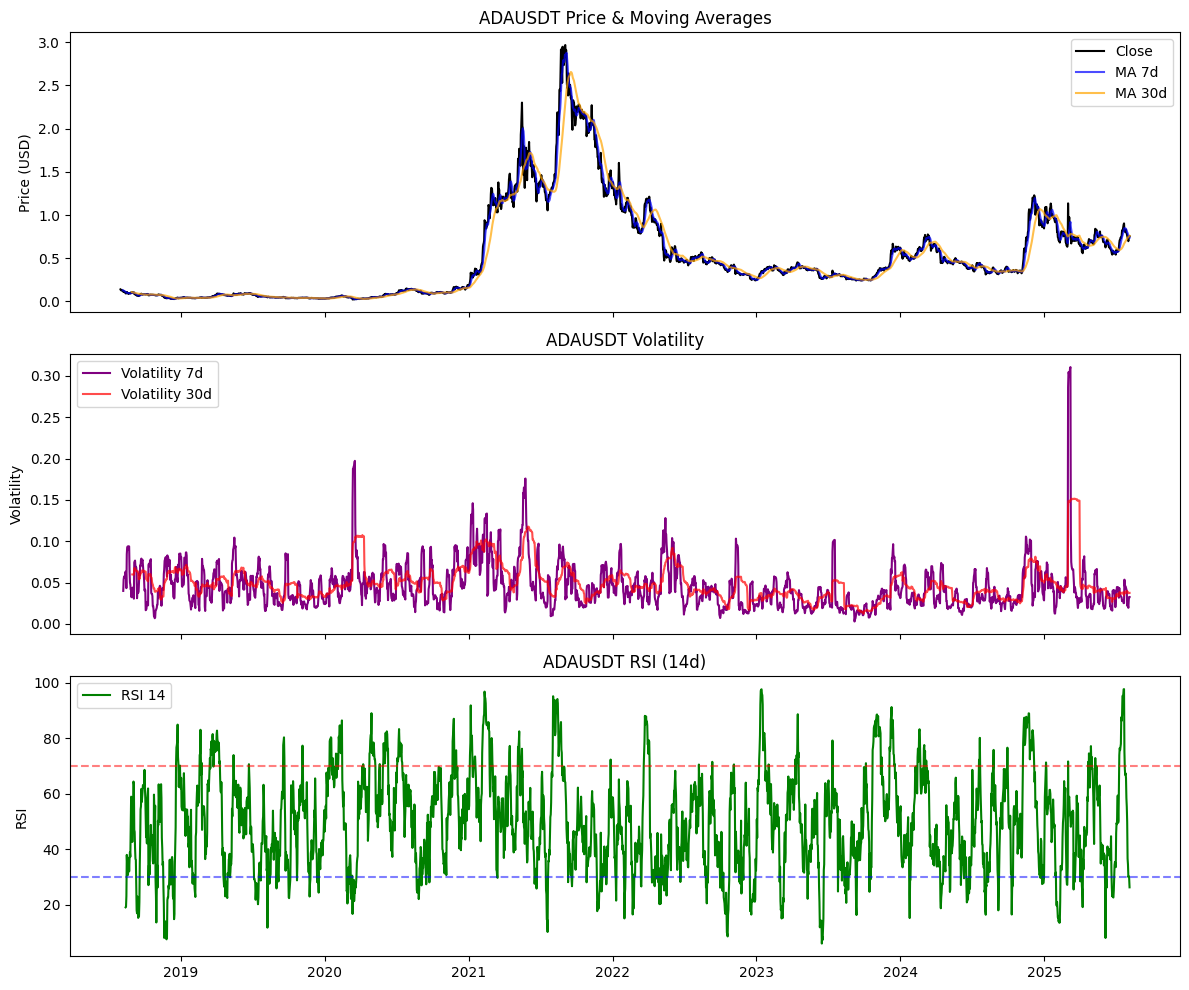

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_features already exists and has the engineered features
df_plot = df_features[df_features['symbol'].isin(['BTCUSDT', 'ADAUSDT'])]

# Set up the plotting function
def plot_coin_features(symbol):
    coin_df = df_plot[df_plot['symbol'] == symbol]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Price + Moving Averages
    axes[0].plot(coin_df['date'], coin_df['close'], label='Close', color='black')
    axes[0].plot(coin_df['date'], coin_df['ma_7d'], label='MA 7d', color='blue', alpha=0.7)
    axes[0].plot(coin_df['date'], coin_df['ma_30d'], label='MA 30d', color='orange', alpha=0.7)
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    axes[0].set_title(f'{symbol} Price & Moving Averages')

    # Volatility
    axes[1].plot(coin_df['date'], coin_df['volatility_7d'], label='Volatility 7d', color='purple')
    axes[1].plot(coin_df['date'], coin_df['volatility_30d'], label='Volatility 30d', color='red', alpha=0.7)
    axes[1].set_ylabel('Volatility')
    axes[1].legend()
    axes[1].set_title(f'{symbol} Volatility')

    # RSI
    axes[2].plot(coin_df['date'], coin_df['rsi_14'], label='RSI 14', color='green')
    axes[2].axhline(70, color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(30, color='blue', linestyle='--', alpha=0.5)
    axes[2].set_ylabel('RSI')
    axes[2].legend()
    axes[2].set_title(f'{symbol} RSI (14d)')

    plt.tight_layout()
    return fig

# Plot for BTC and ADA
fig1 = plot_coin_features('BTCUSDT')
fig2 = plot_coin_features('ADAUSDT')



# ---- Time-based split ----
# Choose a cut-off date for train/test (e.g. last 6 months as test)
cutoff_date = df_features['date'].max() - pd.Timedelta(days=180)
train_df = df_features[df_features['date'] <= cutoff_date]
test_df = df_features[df_features['date'] > cutoff_date]

print('Train range:', train_df['date'].min(), 'to', train_df['date'].max())
print('Test range:', test_df['date'].min(), 'to', test_df['date'].max())

# ML Models

In [20]:
train_df.columns

Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'network', 'return',
       'btc_return', 'excess_return', 'volatility_7d', 'ma_7d',
       'volatility_30d', 'ma_30d', 'rsi_14', 'coin_age', 'target'],
      dtype='object')

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [22]:
# Drop rows with NaNs in features or target
train_df = train_df.dropna()
test_df = test_df.dropna()

In [23]:
FEATURES = [
    col for col in train_df.columns
    if col not in ['close', 'target', 'date', 'symbol']
    and pd.api.types.is_numeric_dtype(train_df[col])
]

X_train = train_df[FEATURES]
y_train = train_df['target']
X_test = test_df[FEATURES]
y_test = test_df['target']


In [24]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                            subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
                            random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1,
                              subsample=0.8, colsample_bytree=0.8,
                              random_state=42, n_jobs=-1, verbose=-1),
    "CatBoost": CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6,
                                  verbose=0, random_seed=42)
}


In [25]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })


In [26]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df.to_string(index=False))

           Model     RMSE      MAE        R²
LinearRegression 0.500103 0.499690 -0.000524
        CatBoost 0.502219 0.497938 -0.009011
    RandomForest 0.503608 0.500304 -0.014600
         XGBoost 0.505842 0.496087 -0.023622
        LightGBM 0.512249 0.497788 -0.049715
